# EKF-Based localization with ICP-RANSAC update/correction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Ellipse
import random
from scipy.spatial import cKDTree
import FFLS
import ICP

## Create the Map

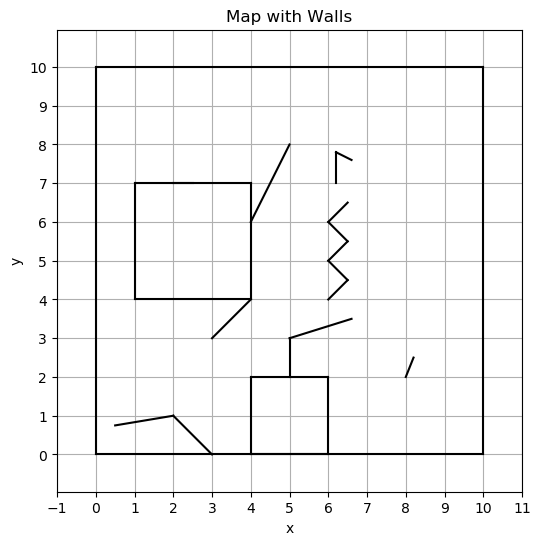

In [2]:
# Define the walls (10x10 grid map)
walls = [
    [(0, 0), (10, 0)],
    [(10, 0), (10, 10)],
    [(10, 10), (0, 10)],
    [(0, 10), (0, 0)]
]
# Add objects
walls += [
    [(3, 3), (4., 4.)],
    [(6, 4), (6.5, 4.5)],
    [(6.5, 4.5), (6, 5)],
    [(6.5, 5.5), (6, 5)],
    [(6.5, 6.5), (6, 6)],
    [(6.5, 5.5), (6, 6)],
    [(2, 7), (2.5, 7)],
    [(8, 2), (8.2, 2.5)],
    [(4,6),(5,8)]
]

walls += [
    [(1, 4), (1, 7)],
    [(1, 7), (4, 7)],
    [(1, 4), (4, 4)],
    [(4, 4), (4, 7)]
]

walls += [
    [(4, 0), (6, 0)],
    [(4, 2), (6, 2)],
    [(4, 0), (4, 2)],
    [(6, 0), (6, 2)]
]


walls += [
    [(2, 1), (3.0, 0.)],
    [(2, 1), (0.5, 0.75)],
    [(6.2, 7.8), (6.2, 7.0)],
    [(6.2, 7.8), (6.6, 7.6)],
    [(5.0, 3.), (5., 2)],
    [(5.0, 3), (6.6, 3.5)]
]


plt.figure(figsize=(6, 6))
# Plot the walls as black
for (x0, y0), (x1, y1) in walls:
    plt.plot([x0, x1], [y0, y1], 'k-') 

plt.title("Map with Walls")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')
plt.ylim(0,10)
plt.xlim(0,10)
plt.xticks([-1,0,1, 2, 3, 4, 5,6,7,8,9,10,11])
plt.yticks([-1,0,1, 2, 3, 4, 5,6,7,8,9,10,11])
plt.show()

## Robot's Movement

In [3]:
def normalize_angle(angle):
    ''' Return angle between (-pi,pi] rad
    '''
    return (angle + np.pi)%(2*np.pi)-np.pi

def add_noise(d, noise_pct):
    ''' Add Gaussian noise for all elements of an array
    '''
    return [x + random.gauss(0, noise_pct * x) for x in d]

### a) Velocity Motion Model

In [4]:
def move_vel(x, u, dt):
    ''' x = (x,y,theta) - initial pose
        u = (v,omega) - control input (linear and angular velocity)
        dt - duration of the movement
    '''
    x_pos, y_pos, theta = x
    v, w = u

    if abs(w) < 1e-6: # straight line
        x_pos += v * np.cos(theta) * dt
        y_pos += v * np.sin(theta) * dt
    else: # circular motion
        r = v/w
        x_pos += -r*np.sin(theta)+r*np.sin(theta+w*dt)
        y_pos += r*np.cos(theta)-r*np.cos(theta+w*dt)
        theta += w*dt
        theta = normalize_angle(theta)
    
    return np.array([x_pos,y_pos,theta])

### b) Odometry Motion Model

In [5]:
def move_odom(x, u):
    ''' 
    x = (x, y, theta) - current estimate of the robot's pose
    u = (x_bar_before, x_bar_after) - odometry readings at t-1 and t
    '''
    x_bar_before, x_bar_after = u
    x_pos, y_pos, theta = x

    # Calculate odometry-based motion (delta)
    delta_rot1 = normalize_angle(
        np.arctan2(x_bar_after[1] - x_bar_before[1], x_bar_after[0] - x_bar_before[0]) - x_bar_before[2]
    )
    delta_trans = np.sqrt((x_bar_after[0] - x_bar_before[0])**2 + (x_bar_after[1] - x_bar_before[1])**2)
    delta_rot2 = normalize_angle(x_bar_after[2] - x_bar_before[2] - delta_rot1)

    # Apply delta to current pose estimate
    x_pos += delta_trans * np.cos(theta + delta_rot1)
    y_pos += delta_trans * np.sin(theta + delta_rot1)
    theta += delta_rot1 + delta_rot2
    theta = normalize_angle(theta)

    return np.array([x_pos, y_pos, theta]), delta_rot1, delta_trans, delta_rot2

### Test robot's movement models over a trajectory

In [6]:
# Define parameters - we can change velocity and initial pose for our simulation
x0 = np.array([1.0, 2.0, np.deg2rad(4)])  # initial pose
u1 = (1, np.deg2rad(10))
u2 = (1.0, np.deg2rad(20))
u3 = (1.0, np.deg2rad(-15))
dt = 0.1
n_steps = 90
u_list = [u1] * (n_steps//3) + [u2] * (n_steps//3) + [u3] * (n_steps//3)

# Trajectories
trajectory_vel = [x0.copy()]
trajectory_odom = [x0.copy()]
odom_readings = [x0.copy()]  # will store "odometry pose"

In [7]:
# Generate trajectory with velocity model
x_vel = x0.copy()
for u in u_list:
    x_vel = move_vel(x_vel, u, dt)
    trajectory_vel.append(x_vel.copy())
    odom_readings.append(add_noise(x_vel.copy(),0.005))

trajectory_vel = np.array(trajectory_vel)

In [8]:
# Generate trajectory with odometry model (from odom_readings)
x_odom = x0.copy()
for i in range(1, len(odom_readings)):
    x_odom, _, _, _ = move_odom(x_odom, (odom_readings[i - 1], odom_readings[i]))
    trajectory_odom.append(x_odom.copy())

trajectory_odom = np.array(trajectory_odom)

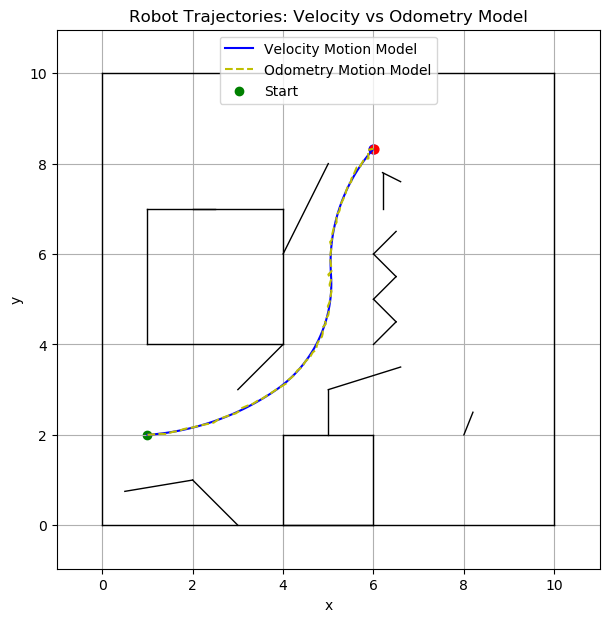

In [9]:
# Plotting
plt.figure(figsize=(7, 7))
plt.plot(trajectory_vel[:, 0], trajectory_vel[:, 1], 'b-', label='Velocity Motion Model')
plt.plot(trajectory_odom[:, 0], trajectory_odom[:, 1], 'y--', label='Odometry Motion Model')
plt.scatter(x0[0], x0[1], color='green', label='Start')
plt.scatter(trajectory_vel[-1, 0], trajectory_vel[-1, 1], color='blue', s=40)
plt.scatter(trajectory_odom[-1, 0], trajectory_odom[-1, 1], color='red', s=40)

# Add bounding box (walls)
for (x0w, y0w), (x1w, y1w) in walls:
    plt.plot([x0w, x1w], [y0w, y1w], 'k-', linewidth=1)

plt.title("Robot Trajectories: Velocity vs Odometry Model")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.xlim(-1, 11)
plt.ylim(-1, 11)
plt.show()

## Scan Matching

### Orthogonal Procrustes Problem

Take a look at ICP.best_fit_transform.

### Nearest Neighbor

The authors used KDTree to solve this problem.

## Fake LiDAR Scans

### Test a LiDAR scan (functions defined in FFLS.py)

In [10]:
pose = np.array([1.0, 2.0, np.deg2rad(4)])

cell_size = 0.5
grid = FFLS.build_wall_grid(walls, cell_size)
grid_bounds = (10, 10)

scan = FFLS.fast_lidar_scan(pose, grid, grid_bounds, cell_size)

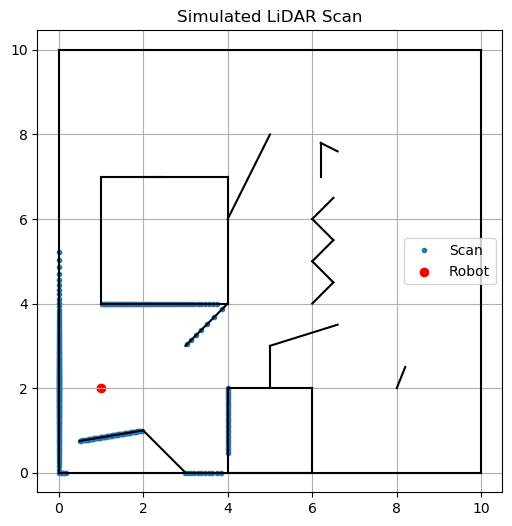

In [11]:
# Plot
angles = scan['angles'] 
ranges = scan['ranges']

# Remove invalid or infinite ranges
ranges = np.where(np.isfinite(ranges), ranges, np.nan)

# Convert to Cartesian in *robot frame*
x_lidar = ranges * np.cos(angles)
y_lidar = ranges * np.sin(angles)

# Translate to global frame (robot at pose)
xs = pose[0] + x_lidar * np.cos(pose[2]) - y_lidar * np.sin(pose[2])
ys = pose[1] + x_lidar * np.sin(pose[2]) + y_lidar * np.cos(pose[2])

plt.figure(figsize=(6,6))
plt.plot(xs, ys, '.', label='Scan')
plt.scatter(pose[0], pose[1], c='r', label='Robot')
for (x0, y0), (x1, y1) in walls:
    plt.plot([x0, x1], [y0, y1], 'k-')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Simulated LiDAR Scan")
plt.show()

## EKF Localization

In [12]:
def EKF(mu_0, Sigma_0, u, z, m, tolerance=0.1, Q=None, R=None):
    """
    Extended Kalman Filter for localization using odometry and ICP.
    
    Inputs:
        mu_0:        np.array(3,) previous state mean
        Sigma_0:     np.array(3,3) previous state covariance
        u:           (x_bar_before, x_bar_after) tuple of odometry readings
        z:           np.array(N,2) LiDAR scan (in robot frame)
        m:           np.array(M,2) map points
        tolerance:   Mahalanobis distance threshold for accepting update
        Q:           np.array(3,3) motion noise covariance (prediction)
        R:           np.array(3,3) measurement noise covariance (update)

    Returns:
        mu:          updated mean
        Sigma:       updated covariance
    """
    
    if Q is None:
        Q = np.diag([0.05, 0.05, np.deg2rad(2)])**2  # Default motion noise
    if R is None:
        R = np.diag([0.1, 0.1, np.deg2rad(2)])**2   # Default ICP measurement noise

    # PREDICTION 
    mu_bar, delta_rot1, delta_trans, _ = move_odom(mu_0, u)

    F = np.array([
        [1, 0, -delta_trans * np.sin(mu_0[2] + delta_rot1)],
        [0, 1,  delta_trans * np.cos(mu_0[2] + delta_rot1)],
        [0, 0, 1]
    ])

    Sigma_bar = F @ Sigma_0 @ F.T + Q

    # UPDATE (Scan Matching via ICP)
    init_T_guess = np.array([
        [np.cos(mu_bar[2]), -np.sin(mu_bar[2]), mu_bar[0]],
        [np.sin(mu_bar[2]),  np.cos(mu_bar[2]), mu_bar[1]],
        [0,              0,             1]
    ])
    T_icp, err = ICP.robust_icp_pipeline(z, m, init_pose=init_T_guess,ransac_threshold=0.3, best_n_inlier=200, max_icp_iter=20, max_points=360)

    # Get the estimated rotation and translation
    R_est = T_icp[:2, :2]
    t_est = T_icp[:2, 2]
    # Get the angle from the rotation matrix
    angle_est = np.arctan2(R_est[1, 0], R_est[0, 0])
    # angle_est = np.rad2deg(angle_est)
    z_obs = np.array([t_est[0], t_est[1], angle_est])
    
    # Innovation
    y = z_obs - mu_bar
    y[2] = normalize_angle(y[2])
    H = np.eye(3)

    S = H @ Sigma_bar @ H.T + R
    d2 = y.T @ np.linalg.inv(S) @ y  # Mahalanobis distance
    
    if d2 <= tolerance:
        K = Sigma_bar @ H.T @ np.linalg.inv(S)
        mu = mu_bar + K @ y
        Sigma = (np.eye(3) - K @ H) @ Sigma_bar
    else:
        mu = mu_bar
        Sigma = Sigma_bar

    return mu, Sigma, z_obs

### Test 

In [13]:
cell_size = 0.01
grid = FFLS.build_wall_grid(walls, cell_size)
grid_bounds = (10, 10)

# --- Noise Matrices ---
Q = np.diag([0.01, 0.01, np.deg2rad(0.5)])**2       # Prediction noise (odometry)
R = np.diag([1., 1., np.deg2rad(2)])**2             # ICP measurement noise (more uncertain)

# --- Initialization ---
mu = np.array([5, 5, np.deg2rad(3.0)])  # Initial pose
Sigma = np.eye(3) * 10                  # Initial uncertainty

z_obs_init = np.array([0, 0, 0])        # Initial observation (LiDAR scan)

mu_list = [mu.copy()]
Sigma_list = [Sigma.copy()]
z_obs_list = [z_obs_init.copy()]
scan_points_list = []

# --- Map: sample dense points from walls ---
def sample_points_from_walls(walls, num_points=50):
    points = []
    for (x0, y0), (x1, y1) in walls:
        for i in np.linspace(0, 1, num_points):
            x = x0 + i * (x1 - x0)
            y = y0 + i * (y1 - y0)
            points.append([x, y])
    return np.array(points)

map_points = sample_points_from_walls(walls, num_points=200)

# --- Run EKF through the trajectory ---
for t in range(1, len(trajectory_vel)):
    # Odometry readings (used in prediction)
    u = (odom_readings[t - 1], odom_readings[t])

    # Simulate LiDAR scan from ground truth
    scan = FFLS.fast_lidar_scan(trajectory_vel[t], grid, grid_bounds, cell_size)

    # Plot
    angles = scan['angles'] 
    ranges = scan['ranges']

    # Remove invalid or infinite ranges
    ranges = np.where(np.isfinite(ranges), ranges, np.nan)

    # Convert to Cartesian in *robot frame*
    x_lidar = ranges * np.cos(angles)
    y_lidar = ranges * np.sin(angles)

    scan_points = np.column_stack([x_lidar, y_lidar])
    
    # FOR ANIMATION:
    # Translate to global frame (robot at pose)
    pose = trajectory_vel[t]
    xs = pose[0] + x_lidar * np.cos(pose[2]) - y_lidar * np.sin(pose[2])
    ys = pose[1] + x_lidar * np.sin(pose[2]) + y_lidar * np.cos(pose[2])
    scan_points_world_frame = np.column_stack([xs, ys])
    scan_points_list.append(scan_points_world_frame.copy())

    scan_points = scan_points[np.isfinite(scan_points).all(axis=1)]
    
    # Clean map too (if dynaamic walls ever break things)
    map_points = map_points[np.isfinite(map_points).all(axis=1)]

    # EKF step
    mu, Sigma, z_obs = EKF(mu, Sigma, u, scan_points, map_points, tolerance=10.0, R=R, Q=Q)

    mu_list.append(mu.copy())
    Sigma_list.append(Sigma.copy())
    z_obs_list.append(z_obs.copy())

Only 144 inliers ---> Starting grid search for GO-ICP
Only 162 inliers ---> Starting grid search for GO-ICP
Initial pose used with inliers:  316
Initial pose used with inliers:  316
Initial pose used with inliers:  315
Initial pose used with inliers:  330
Initial pose used with inliers:  332
Initial pose used with inliers:  331
Initial pose used with inliers:  331
Initial pose used with inliers:  329
Initial pose used with inliers:  328
Initial pose used with inliers:  326
Initial pose used with inliers:  325
Initial pose used with inliers:  325
Initial pose used with inliers:  323
Initial pose used with inliers:  321
Initial pose used with inliers:  321
Initial pose used with inliers:  319
Initial pose used with inliers:  317
Initial pose used with inliers:  313
Initial pose used with inliers:  308
Initial pose used with inliers:  301
Initial pose used with inliers:  297
Initial pose used with inliers:  290
Initial pose used with inliers:  283
Initial pose used with inliers:  274
Init

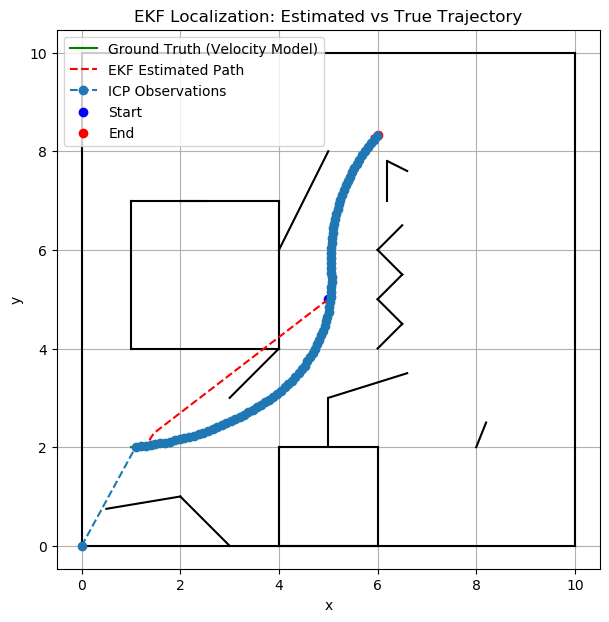

In [14]:
mu_arr = np.array(mu_list)
z_obs_arr = np.array(z_obs_list)

plt.figure(figsize=(7, 7))
plt.plot(trajectory_vel[:, 0], trajectory_vel[:, 1], 'g-', label='Ground Truth (Velocity Model)')
for (x0, y0), (x1, y1) in walls:
    plt.plot([x0, x1], [y0, y1], 'k-')  # black walls
plt.plot(mu_arr[:, 0], mu_arr[:, 1], 'r--', label='EKF Estimated Path')
plt.plot(z_obs_arr[:, 0], z_obs_arr[:, 1], 'o--', label='ICP Observations')

plt.scatter(mu_arr[0, 0], mu_arr[0, 1], color='blue', label='Start')
plt.scatter(mu_arr[-1, 0], mu_arr[-1, 1], color='red', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.title('EKF Localization: Estimated vs True Trajectory')
plt.show()

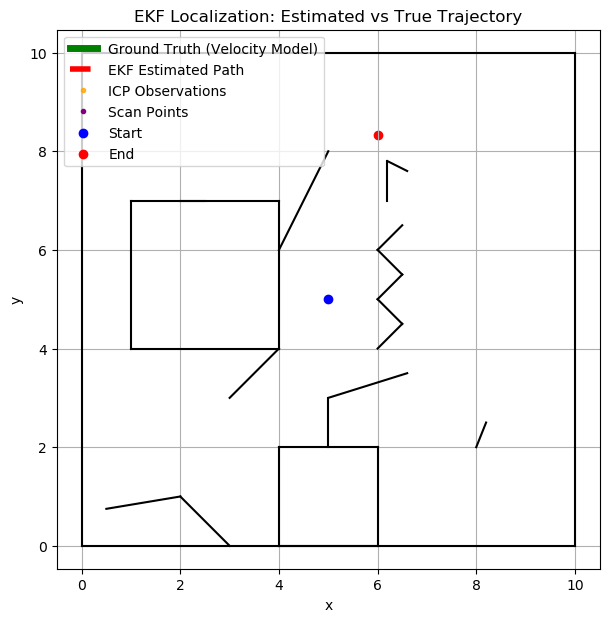

In [15]:
mu_arr = np.array(mu_list)
z_obs_arr = np.array(z_obs_list)

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('EKF Localization: Estimated vs True Trajectory')
ax.grid(True)
ax.axis('equal')

# Plot the static parts (walls)
for (x0, y0), (x1, y1) in walls:
    ax.plot([x0, x1], [y0, y1], 'k-')  # black walls

# Initialize plot elements to be updated
gt_line, = ax.plot([], [], 'g-', label='Ground Truth (Velocity Model)', linewidth=5)
mu_line, = ax.plot([], [], 'r--', label='EKF Estimated Path', linewidth=4)
obs_scatter = ax.plot([], [], 'o', color='orange', label='ICP Observations', markersize=3, alpha=0.8)[0]
scan_scatter = ax.plot([], [], '.', color='purple', label='Scan Points')[0]
arrow = None  # Arrow for observation direction

# Static start and end markers
ax.scatter(mu_arr[0, 0], mu_arr[0, 1], color='blue', label='Start')
ax.scatter(mu_arr[-1, 0], mu_arr[-1, 1], color='red', label='End')

ax.legend()

def init():
    gt_line.set_data([], [])
    mu_line.set_data([], [])
    obs_scatter.set_data([], [])
    scan_scatter.set_data([], [])
    global arrow
    if arrow is not None:
        arrow.remove()
        arrow = None
    return gt_line, mu_line, obs_scatter, scan_scatter

def update(frame):
    global arrow
    gt_line.set_data(trajectory_vel[:frame+1, 0], trajectory_vel[:frame+1, 1])
    mu_line.set_data(mu_arr[:frame+1, 0], mu_arr[:frame+1, 1])
    obs_scatter.set_data(z_obs_arr[:frame+1, 0], z_obs_arr[:frame+1, 1])
    scan_points = scan_points_list[frame]
    if len(scan_points) > 0:
        scan_scatter.set_data(scan_points[:, 0], scan_points[:, 1])
    else:
        scan_scatter.set_data([], [])
    # Remove previous arrow
    if arrow is not None:
        arrow.remove()
        arrow = None
    # Draw arrow at current observation
    x, y, theta = z_obs_arr[frame]
    dx = 0.4 * np.cos(theta)
    dy = 0.4 * np.sin(theta)
    arrow = ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.2, fc='orange', ec='orange')
    return gt_line, mu_line, obs_scatter, scan_scatter, arrow

num_frames = min(len(mu_arr), len(z_obs_arr), len(trajectory_vel), len(scan_points_list))

ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=False, interval=100)

# Optional: Save the animation
#ani.save('ekf_animation.mp4', writer='ffmpeg', fps=10)

plt.show()

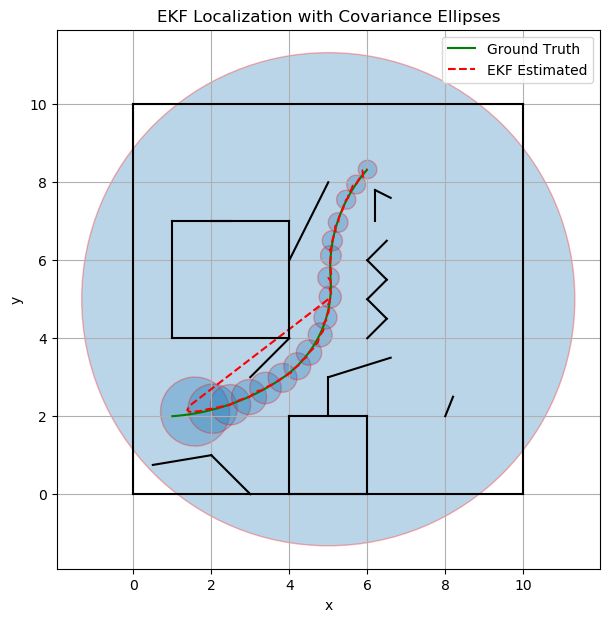

In [16]:
def plot_cov_ellipse(ax, mu, Sigma, n_std=2.0, **kwargs):
    eigvals, eigvecs = np.linalg.eigh(Sigma[:2, :2])
    angle = np.arctan2(*eigvecs[:, 0][::-1])
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mu[:2], width=width, height=height,
                      angle=np.degrees(angle), **kwargs)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(trajectory_vel[:, 0], trajectory_vel[:, 1], 'g-', label='Ground Truth')
ax.plot(mu_arr[:, 0], mu_arr[:, 1], 'r--', label='EKF Estimated')

for i in range(0, len(mu_arr), 5):
    plot_cov_ellipse(ax, mu_arr[i], Sigma_list[i], alpha=0.3, edgecolor='red')

for (x0, y0), (x1, y1) in walls:
    ax.plot([x0, x1], [y0, y1], 'k-')  # black walls

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('EKF Localization with Covariance Ellipses')
ax.grid(True)
ax.axis('equal')
ax.legend()
plt.show()